In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


In [2]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

In [3]:
lag_time_features = [f'TVV_Lag{i}' for i in range(1, 7)] + ['year', 'month', 'quarter']
feature_sets = {
    'Lag Only': lag_time_features,
    'All Features': [col for col in df_lagged.columns if col not in ['Periode', 'Totaal_verkochte_wegvoertuigen']]


}


# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    ' (Lag Only)': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features


In [4]:
def walk_forward_nested_gridsearch(
    df, features, target_col, model_class, param_grid,
    forecast_horizon=3, validation_size=3, inner_val_size=3
):
    from sklearn.model_selection import ParameterGrid

    X = df[features].values
    y = df[target_col].values

    initial_train_size = min(int(len(df) * 0.8), len(df) - forecast_horizon - 1)

    test_predictions, test_actuals = [], []
    validation_predictions, validation_actuals = [], []
    validation_dates, test_dates = [], []

    for i in range(initial_train_size, len(df) - forecast_horizon - validation_size + 1):
        X_train, y_train = X[:i], y[:i]

        # Split voor nested tuning
        if i < inner_val_size + 5:
            continue  # te weinig data om tuning te doen
        X_inner_train = X_train[:-inner_val_size]
        y_inner_train = y_train[:-inner_val_size]
        X_inner_val = X_train[-inner_val_size:]
        y_inner_val = y_train[-inner_val_size:]

        best_params = None
        best_score = float('inf')

        for params in ParameterGrid(param_grid):
            model = model_class(**params)
            model.fit(X_inner_train, y_inner_train)
            preds = model.predict(X_inner_val)
            score = mean_absolute_percentage_error(y_inner_val, preds)
            if score < best_score:
                best_score = score
                best_params = params

        # Model met beste params opnieuw trainen op hele train set
        best_model = model_class(**best_params)
        best_model.fit(X_train, y_train)

        # Validation & test sets
        X_val = X[i : i + validation_size]
        y_val = y[i : i + validation_size]
        X_test = X[i + validation_size : i + validation_size + forecast_horizon]
        y_test = y[i + validation_size : i + validation_size + forecast_horizon]

        val_preds = best_model.predict(X_val)
        validation_predictions.extend(val_preds)
        validation_actuals.extend(y_val)
        validation_dates.extend(df.iloc[i:i+validation_size]['Periode'].values)

        test_preds = best_model.predict(X_test)
        test_predictions.extend(test_preds)
        test_actuals.extend(y_test)
        test_dates.extend(df.iloc[i + validation_size : i + validation_size + forecast_horizon]['Periode'].values)

    # Evaluatie
    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)
    validation_predictions = np.array(validation_predictions)
    validation_actuals = np.array(validation_actuals)

    mae = mean_absolute_error(test_actuals, test_predictions)
    rmse = np.sqrt(mean_squared_error(test_actuals, test_predictions))
    r2 = r2_score(test_actuals, test_predictions)
    mape = mean_absolute_percentage_error(test_actuals, test_predictions)

    val_mae = mean_absolute_error(validation_actuals, validation_predictions)
    val_rmse = np.sqrt(mean_squared_error(validation_actuals, validation_predictions))
    val_r2 = r2_score(validation_actuals, validation_predictions)
    val_mape = mean_absolute_percentage_error(validation_actuals, validation_predictions)

    return (
        mae, rmse, r2, mape,
        test_predictions, test_actuals,
        val_mae, val_rmse, val_r2, val_mape,
        validation_predictions, validation_actuals,
        validation_dates, test_dates
    )


#### Nulmodel

Random Walk Null Model ( (Lag Only)) [zelfde valset]: MAPE=0.1546, MAE=3239.53, RMSE=4534.33, R²=0.235


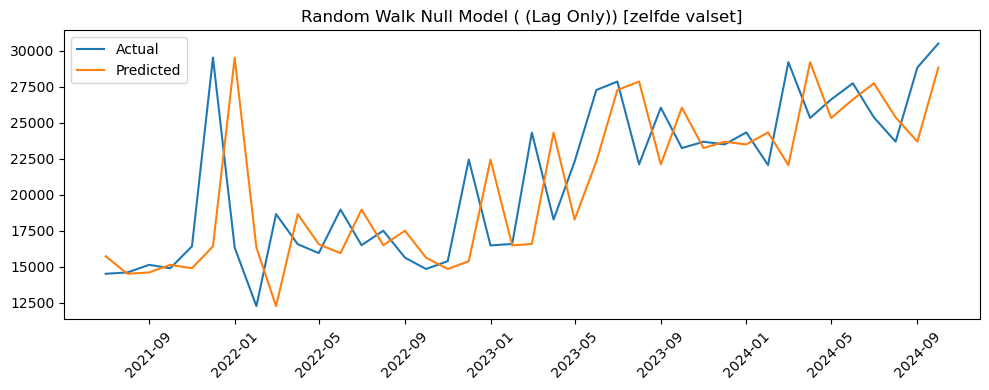

Random Walk Null Model (All Features) [zelfde valset]: MAPE=0.1546, MAE=3239.53, RMSE=4534.33, R²=0.235


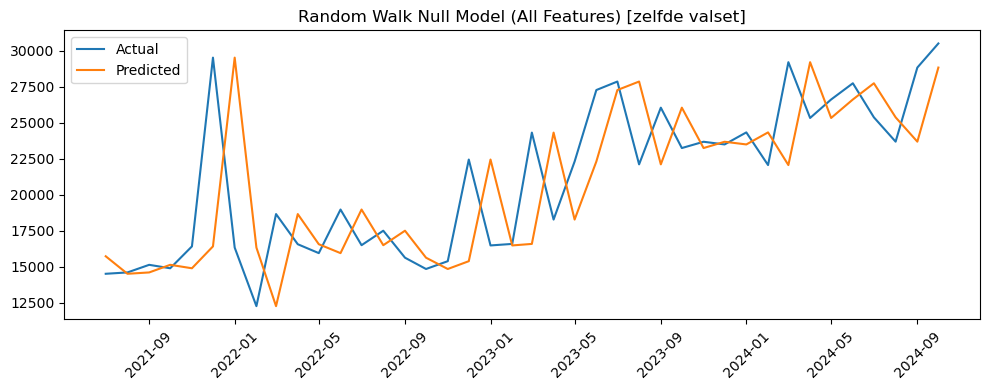

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# 1. Haal de validation_dates van XGBoost via walk_forward_nested_gridsearch
_, _, _, _, _, _, _, _, _, _, _, _, xgb_validation_dates, _ = walk_forward_nested_gridsearch(
    df_lagged,
    feature_sets['All Features'],
    'Totaal_verkochte_wegvoertuigen',
    xgb.XGBRegressor,
    {
        'objective': ['reg:squarederror'],
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3],
        'random_state': [42],
        'eval_metric': ['rmse']
    },
    validation_size=3,
    forecast_horizon=3,
    inner_val_size=3
)
xgb_validation_dates = pd.to_datetime(xgb_validation_dates)

# 2. Random Walk evaluatie op dezelfde datums als XGBoost
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    val_preds = df_lagged['TVV_Lag1'].values
    val_actuals = df_lagged['Totaal_verkochte_wegvoertuigen'].values
    validation_dates = pd.to_datetime(df_lagged['Periode'].values)

    # Filter op dezelfde datums als XGBoost validation set
    mask = validation_dates.isin(xgb_validation_dates)
    val_preds = val_preds[mask]
    val_actuals = val_actuals[mask]
    validation_dates = validation_dates[mask]

    val_mae = mean_absolute_error(val_actuals, val_preds)
    val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
    val_r2 = r2_score(val_actuals, val_preds)
    val_mape = mean_absolute_percentage_error(val_actuals, val_preds)

    print(f"Random Walk Null Model ({label}) [zelfde valset]: MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")

    df_plot = pd.DataFrame({
        'date': validation_dates,
        'actual': val_actuals,
        'pred': val_preds
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'Random Walk Null Model ({label}) [zelfde valset]')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Baseline

In [ ]:
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates,_
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen', 
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                                learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
     validation_size=3, forecast_horizon=3
    )
    print(f"XGBoost ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")

    # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(validation_dates),
        'actual': val_actuals,
        'pred': val_preds
    })
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'XGBoost ({label})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

NameError: name 'walk_forward_validation_with_validation_set' is not defined

: 

#### Arimax

ARIMAX ( (Lag Only)): MAPE=0.1765, MAE=3621.76, RMSE=5079.97, R²=-0.062


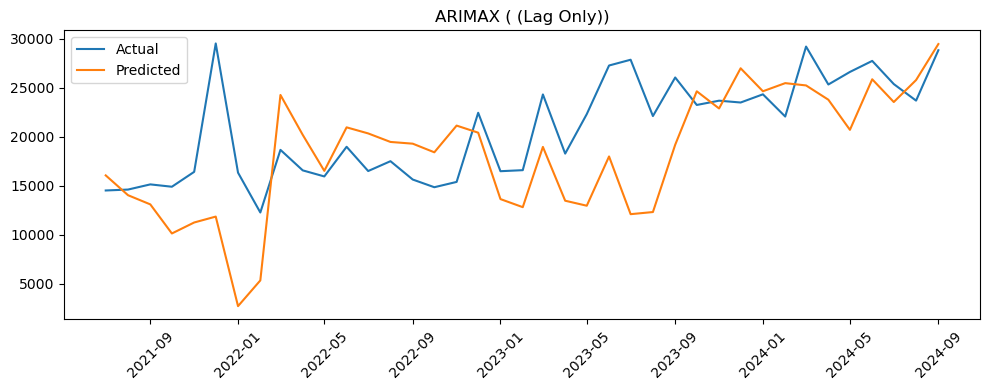

ARIMAX (All Features): MAPE=0.1417, MAE=3006.97, RMSE=4635.71, R²=0.116


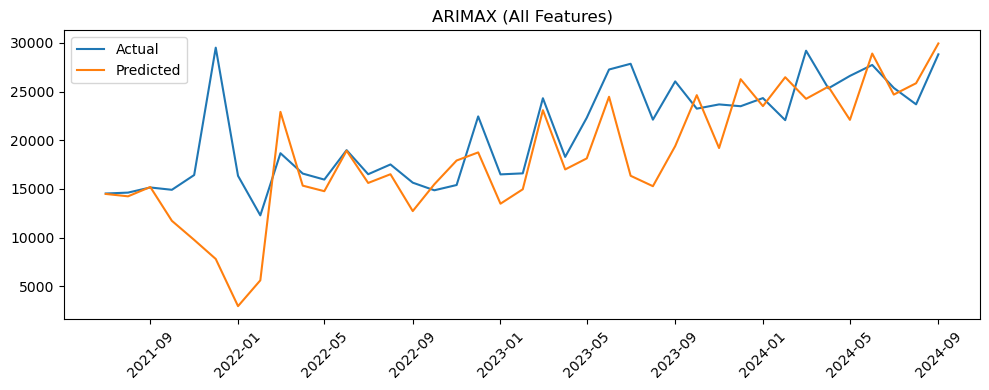

In [66]:
from sklearn.preprocessing import StandardScaler

# ARIMAX wrapper met standaardisatie
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None  # om later opnieuw te gebruiken bij predict
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        # Standaardiseer de exogene variabelen
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        
        model = SARIMAX(y, exog=X_scaled, order=self.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)
for label, features in feature_sets.items():
    if label not in [' (Lag Only)', 'All Features']:
        continue  # Sla andere feature sets over

    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates,_
    ) = walk_forward_validation_with_validation_set(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: ARIMAXWrapper(order=(1, 1, 1)),
        
    )

    print(f"ARIMAX ({label}): MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")

    # Zet alles in een DataFrame om dubbele datums te verwijderen
    df_plot = pd.DataFrame({
        'date': pd.to_datetime(validation_dates),
        'actual': val_actuals,
        'pred': val_preds
    })
    df_plot = df_plot.drop_duplicates(subset='date', keep='first')
    
    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'ARIMAX ({label})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



### Fine tune 

> Iteratie 1: max_depth

In [8]:
for max_depth in [1, 2, 3, 5, 7, 9]:
    print(f"\nTesting max_depth={max_depth}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=max_depth,
            subsample=1.0,
            min_child_weight=1,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"max_depth={max_depth} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing max_depth=1
max_depth=1 | MAPE=0.1637, MAE=3492.81, RMSE=5076.15, R²=-0.060

Testing max_depth=2
max_depth=2 | MAPE=0.1460, MAE=3213.00, RMSE=4176.51, R²=0.282

Testing max_depth=3
max_depth=3 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing max_depth=5
max_depth=5 | MAPE=0.1385, MAE=3002.46, RMSE=4019.67, R²=0.335

Testing max_depth=7
max_depth=7 | MAPE=0.1463, MAE=3166.35, RMSE=4153.12, R²=0.290

Testing max_depth=9
max_depth=9 | MAPE=0.1461, MAE=3161.13, RMSE=4147.56, R²=0.292


> Iteratie 2: min_child_weight

In [9]:
for min_child_weight in [1, 3, 5, 7, 10]:
    print(f"\nTesting min_child_weight={min_child_weight}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=min_child_weight,
            subsample=1.0,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"min_child_weight={min_child_weight} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing min_child_weight=1
min_child_weight=1 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing min_child_weight=3
min_child_weight=3 | MAPE=0.1732, MAE=3615.83, RMSE=4517.39, R²=0.160

Testing min_child_weight=5
min_child_weight=5 | MAPE=0.2012, MAE=4141.57, RMSE=5080.13, R²=-0.062

Testing min_child_weight=7
min_child_weight=7 | MAPE=0.1966, MAE=4088.51, RMSE=5143.46, R²=-0.088

Testing min_child_weight=10
min_child_weight=10 | MAPE=0.1563, MAE=3416.53, RMSE=4557.62, R²=0.145


> iteratie 3: subsample

In [10]:
for subsample in [1.0, 0.8, 0.6, 0.5]:
    print(f"\nTesting subsample={subsample}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            subsample=subsample,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"subsample={subsample} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing subsample=1.0
subsample=1.0 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing subsample=0.8
subsample=0.8 | MAPE=0.1248, MAE=2651.58, RMSE=3449.26, R²=0.511

Testing subsample=0.6
subsample=0.6 | MAPE=0.1685, MAE=3514.13, RMSE=4385.56, R²=0.209

Testing subsample=0.5
subsample=0.5 | MAPE=0.1819, MAE=3705.26, RMSE=4583.41, R²=0.136


> iteratie 4': colsample_bytree

In [13]:
for colsample_bytree in [1.0, 0.8, 0.6, 0.5]:
    print(f"\nTesting colsample_bytree={colsample_bytree}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            subsample=1.0,
            colsample_bytree=colsample_bytree,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"colsample_bytree={colsample_bytree} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing colsample_bytree=1.0
colsample_bytree=1.0 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing colsample_bytree=0.8
colsample_bytree=0.8 | MAPE=0.1317, MAE=2811.39, RMSE=3763.04, R²=0.417

Testing colsample_bytree=0.6
colsample_bytree=0.6 | MAPE=0.1221, MAE=2648.18, RMSE=3607.44, R²=0.465

Testing colsample_bytree=0.5
colsample_bytree=0.5 | MAPE=0.1304, MAE=2815.31, RMSE=3708.91, R²=0.434


> iteratie 5: learning_rate

In [14]:
for learning_rate in [0.3, 0.1, 0.05, 0.01]:
    print(f"\nTesting learning_rate={learning_rate}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=learning_rate,
            max_depth=3,
            min_child_weight=1,
            subsample=1.0,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"learning_rate={learning_rate} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing learning_rate=0.3
learning_rate=0.3 | MAPE=0.1235, MAE=2653.40, RMSE=3615.68, R²=0.462

Testing learning_rate=0.1
learning_rate=0.1 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing learning_rate=0.05
learning_rate=0.05 | MAPE=0.1225, MAE=2679.98, RMSE=3651.00, R²=0.452

Testing learning_rate=0.01
learning_rate=0.01 | MAPE=0.4040, MAE=8545.03, RMSE=9135.97, R²=-2.434


> iteratie 6: n_estimators

In [15]:
for n_estimators in [50, 100, 200, 300]:
    print(f"\nTesting n_estimators={n_estimators}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=n_estimators,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            subsample=1.0,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"n_estimators={n_estimators} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing n_estimators=50
n_estimators=50 | MAPE=0.1206, MAE=2600.57, RMSE=3582.42, R²=0.472

Testing n_estimators=100
n_estimators=100 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing n_estimators=200
n_estimators=200 | MAPE=0.1202, MAE=2580.19, RMSE=3554.01, R²=0.480

Testing n_estimators=300
n_estimators=300 | MAPE=0.1201, MAE=2579.59, RMSE=3549.12, R²=0.482


### iteratie 7: gamma

In [16]:
for gamma in [0, 1, 5, 10]:
    print(f"\nTesting gamma={gamma}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            subsample=1.0,
            colsample_bytree=1.0,
            gamma=gamma,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"gamma={gamma} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing gamma=0
gamma=0 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing gamma=1
gamma=1 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing gamma=5
gamma=5 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing gamma=10
gamma=10 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481


> iteratie 8: reg_alpha

In [17]:
for reg_alpha in [0, 0.1, 1, 10]:
    print(f"\nTesting reg_alpha={reg_alpha}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            subsample=1.0,
            colsample_bytree=1.0,
            gamma=0,
            reg_alpha=reg_alpha,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"reg_alpha={reg_alpha} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing reg_alpha=0
reg_alpha=0 | MAPE=0.1195, MAE=2569.12, RMSE=3550.50, R²=0.481

Testing reg_alpha=0.1
reg_alpha=0.1 | MAPE=0.1200, MAE=2577.90, RMSE=3558.36, R²=0.479

Testing reg_alpha=1
reg_alpha=1 | MAPE=0.1193, MAE=2563.44, RMSE=3548.56, R²=0.482

Testing reg_alpha=10
reg_alpha=10 | MAPE=0.1201, MAE=2570.70, RMSE=3515.87, R²=0.491


> iteratie 9: reg_lambda

In [18]:
for reg_lambda in [1, 0.1, 5, 10]:
    print(f"\nTesting reg_lambda={reg_lambda}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            subsample=1.0,
            colsample_bytree=1.0,
            gamma=0,
            reg_alpha=1,
            reg_lambda=reg_lambda,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"reg_lambda={reg_lambda} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing reg_lambda=1
reg_lambda=1 | MAPE=0.1193, MAE=2563.44, RMSE=3548.56, R²=0.482

Testing reg_lambda=0.1
reg_lambda=0.1 | MAPE=0.1149, MAE=2481.27, RMSE=3300.03, R²=0.552

Testing reg_lambda=5
reg_lambda=5 | MAPE=0.1494, MAE=3182.04, RMSE=4191.44, R²=0.277

Testing reg_lambda=10
reg_lambda=10 | MAPE=0.1832, MAE=3891.89, RMSE=5168.58, R²=-0.099


> iteratie 10: tree_method

In [19]:
for tree_method in ['auto', 'exact', 'hist']:
    print(f"\nTesting tree_method={tree_method}")
    (
         mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=3,
            min_child_weight=1,
            subsample=1.0,
            colsample_bytree=1.0,
            gamma=0,
            reg_alpha=1,
            reg_lambda=0.1,
            tree_method=tree_method,
            random_state=42,
            eval_metric="rmse"
        ),
        validation_size=3,
        forecast_horizon=3
    )
    print(f"tree_method={tree_method} | MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")



Testing tree_method=auto
tree_method=auto | MAPE=0.1149, MAE=2481.27, RMSE=3300.03, R²=0.552

Testing tree_method=exact
tree_method=exact | MAPE=0.1139, MAE=2459.61, RMSE=3289.93, R²=0.555

Testing tree_method=hist
tree_method=hist | MAPE=0.1149, MAE=2481.27, RMSE=3300.03, R²=0.552


### Opslaan beste model

In [23]:
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    reg_alpha=1,
    reg_lambda=0.1,
    tree_method='exact',
    random_state=42,
    eval_metric="rmse"
)

# X en y definiëren (train op volledige dataset)
X = df_lagged[feature_sets['All Features']]
y = df_lagged['Totaal_verkochte_wegvoertuigen']

# Fit model
best_model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [24]:
best_model.save_model("best_xgboost_model.json")


### Test set op model (moved onder gridsearch)

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt

# for label, features in feature_sets.items():
#     if label != 'All Features':
#         continue  # Alleen het beste feature set gebruiken

#     (
#         mae, rmse, r2, mape, preds, actuals,
#         _, _, _, _, _, _, _, test_dates
#     ) = walk_forward_validation_with_validation_set(
#         df_lagged,
#         features,
#         'Totaal_verkochte_wegvoertuigen',
#         lambda: xgb.XGBRegressor(
#             objective='reg:squarederror',
#             max_depth=3,
#             learning_rate=0.1,
#             n_estimators=100,
#             subsample=1.0,
#             min_child_weight=1,
#             colsample_bytree=1.0,
#             gamma=0,
#             reg_alpha=1,
#             reg_lambda=0.1,
#             tree_method='exact',
#             random_state=42,
#             eval_metric='rmse'
#         ),
#         validation_size=None,  # Alleen testset gebruiken
#         forecast_horizon=3
#     )

#     print(f"XGBoost ({label}) - TESTSET:")
#     print(f"MAPE = {mape:.4f}")
#     print(f"MAE  = {mae:.2f}")
#     print(f"RMSE = {rmse:.2f}")
#     print(f"R²   = {r2:.3f}")

#     # Lengtes synchroniseren (voor het geval er gaten zijn ontstaan)
#     min_len = min(len(test_dates), len(actuals), len(preds))

#     df_plot = pd.DataFrame({
#         'date': pd.to_datetime(test_dates[:min_len]),
#         'actual': actuals[:min_len],
#         'pred': preds[:min_len]
#     }).drop_duplicates(subset='date', keep='first')




XGBoost (All Features) - TESTSET:
MAPE = 0.1234
MAE  = 2916.16
RMSE = 4041.37
R²   = 0.529



📊 Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):
month                    2874.011074
thuis opladen             242.893549
Consumentenvertrouwen     117.764931
hybride elektrisch        103.450880
Koopbereidheid             89.215656
Economisch klimaat         88.433351
TVV_Lag3                   28.657150
Grote aankopen             27.397357
BenzineEuro95_1_last       22.850507
TVV_Lag5                   20.589618
TVV_Lag2                   15.837565
TVV_Lag1                    5.354809
TVV_Lag4                    5.024802
BenzineEuro95_1_first       3.664871
TVV_Lag6                    0.000000
year                        0.000000
Diesel_2_mean               0.000000
Diesel_2_first              0.000000
Diesel_2_max                0.000000
Diesel_2_min                0.000000
Diesel_2_last               0.000000
elektrische auto            0.000000
BenzineEuro95_1_mean        0.000000
BenzineEuro95_1_max         0.000000
BenzineEuro95_1_min         

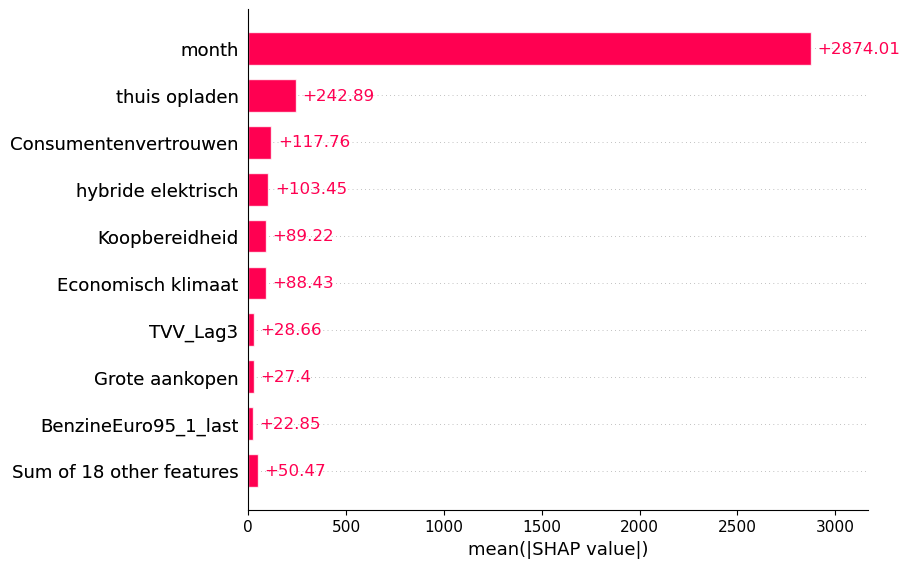

In [34]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1. Verdeel data handmatig in train/test (gelijk aan je walk-forward verdeling)
initial_train_size = int(len(df_lagged) * 0.8)

X_all = df_lagged[feature_sets['All Features']]
y_all = df_lagged['Totaal_verkochte_wegvoertuigen']

X_train = X_all.iloc[:initial_train_size]
y_train = y_all.iloc[:initial_train_size]

X_test = X_all.iloc[initial_train_size:]
y_test = y_all.iloc[initial_train_size:]

# 2. Hertrain je beste model op alle trainingsdata
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    reg_alpha=1,
    reg_lambda=0.1,
    tree_method='exact',
    random_state=42,
    eval_metric='rmse'
)
best_model.fit(X_train, y_train)

# 3. Bereken SHAP-waardes over de testset
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# 4. Toon globale feature importances (tabel of plot)
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)

# Print tabel
print("\n📊 Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):")
print(mean_abs_shap)

# 5. Optioneel: plot
shap.plots.bar(shap_values, max_display=10)  # top 10 meest bepalende features


In [35]:
# Stap 1: Bereken percentages
total_shap = mean_abs_shap.sum()
mean_abs_shap_percent = (mean_abs_shap / total_shap * 100)

# Stap 2: Combineer in een overzichtstabel
shap_summary = pd.DataFrame({
    'Mean(|SHAP|)': mean_abs_shap,
    'Contribution (%)': mean_abs_shap_percent
}).sort_values('Contribution (%)', ascending=False)

# Stap 3: Voeg cumulatief percentage toe (optioneel)
shap_summary['Cumulative (%)'] = shap_summary['Contribution (%)'].cumsum()

# Stap 4: Afronden en printen
shap_summary_rounded = shap_summary.round(2)
print(shap_summary_rounded)

# Stap 5: Controle (zou ongeveer 100% moeten zijn)
print("\nTotaal bijdrage: {:.2f}%".format(shap_summary_rounded['Contribution (%)'].sum()))


                       Mean(|SHAP|)  Contribution (%)  Cumulative (%)
month                       2874.01             78.84           78.84
thuis opladen                242.89              6.66           85.51
Consumentenvertrouwen        117.76              3.23           88.74
hybride elektrisch           103.45              2.84           91.58
Koopbereidheid                89.22              2.45           94.02
Economisch klimaat            88.43              2.43           96.45
TVV_Lag3                      28.66              0.79           97.24
Grote aankopen                27.40              0.75           97.99
BenzineEuro95_1_last          22.85              0.63           98.62
TVV_Lag5                      20.59              0.56           99.18
TVV_Lag2                      15.84              0.43           99.61
TVV_Lag1                       5.35              0.15           99.76
TVV_Lag4                       5.02              0.14           99.90
BenzineEuro95_1_firs

### Grid search

In [21]:
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [1.0, 0.8, 0.6],
    'colsample_bytree': [1.0, 0.8, 0.6],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0.1, 1, 5],
    'gamma': [0, 1]
}


In [46]:
import itertools

# Alle combinaties
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_mape = float('inf')
best_params = None

for i, params in enumerate(combinations):
    print(f"\nTesting combination {i+1}/{len(combinations)}: {params}")

    (
        mae, rmse, r2, mape, preds, actuals,
        val_mae, val_rmse, val_r2, val_mape, val_preds, val_actuals, validation_dates, _
    ) = walk_forward_validation_with_validation_set(
        df_lagged,
        feature_sets['All Features'],
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            random_state=42,
            tree_method='exact',
            **params
        ),
        validation_size=3,
        forecast_horizon=3
    )

    print(f"MAPE={val_mape:.4f}, MAE={val_mae:.2f}, RMSE={val_rmse:.2f}, R²={val_r2:.3f}")

    if val_mape < best_mape:
        best_mape = val_mape
        best_params = params

    


Testing combination 1/2916: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'gamma': 0}
MAPE=0.1142, MAE=2467.55, RMSE=3307.15, R²=0.550

Testing combination 2/2916: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'gamma': 1}
MAPE=0.1142, MAE=2467.55, RMSE=3307.15, R²=0.550

Testing combination 3/2916: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'gamma': 0}
MAPE=0.1172, MAE=2532.80, RMSE=3526.23, R²=0.488

Testing combination 4/2916: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'gamma': 1}
MAPE=0.1172, MAE=2532.80, RMSE=3526.23, R²=0.488


In [ ]:
print("\n Beste parameters volgens grid search:")
print(best_params)
print(f"MAPE: {best_mape:.4f}")




 Beste parameters volgens grid search:
{'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.1, 'gamma': 0}
MAPE: 0.1122


### Test set op model

XGBoost (All Features) - TESTSET:
MAPE = 0.1210
MAE  = 2862.43
RMSE = 4067.13
R²   = 0.523


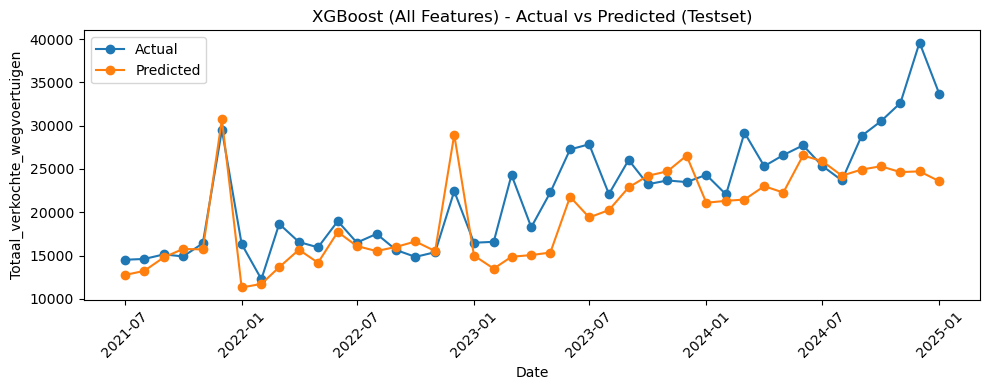

In [63]:
import pandas as pd
import matplotlib.pyplot as plt

for label, features in feature_sets.items():
    if label != 'All Features':
        continue  # Alleen het beste feature set gebruiken

    (
        mae, rmse, r2, mape, preds, actuals,
        _, _, _, _, _, _, _, test_dates
    ) = walk_forward_validation_with_validation_set(
        df_lagged,
        features,
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=3,
            learning_rate=0.05,
            n_estimators=100,
            subsample=1.0,
            min_child_weight=1,
            colsample_bytree=0.8,
            gamma=0,
            reg_alpha=0,
            reg_lambda=0.1,
            tree_method='exact',
            random_state=42,
            eval_metric='rmse'
        ),
        validation_size=None,  # Alleen testset gebruiken
        forecast_horizon=3
    )

    print(f"XGBoost ({label}) - TESTSET:")
    print(f"MAPE = {mape:.4f}")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.3f}")

    # Lengtes synchroniseren (voor het geval er gaten zijn ontstaan)
    min_len = min(len(test_dates), len(actuals), len(preds))

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates[:min_len]),
        'actual': actuals[:min_len],
        'pred': preds[:min_len]
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual', marker='o')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted', marker='o')
    plt.title(f'XGBoost ({label}) - Actual vs Predicted (Testset)')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Default XGBoost op test

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Gebruik dezelfde splits als bij je getunede model
initial_train_size = int(len(df_lagged) * 0.8)

X_all = df_lagged[feature_sets['All Features']]
y_all = df_lagged['Totaal_verkochte_wegvoertuigen']

X_train = X_all.iloc[:initial_train_size]
y_train = y_all.iloc[:initial_train_size]
X_test = X_all.iloc[initial_train_size:]
y_test = y_all.iloc[initial_train_size:]

#  Baseline XGBoost model (default hyperparameters)
baseline_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    eval_metric='rmse'
)

# Train
baseline_model.fit(X_train, y_train)

# Voorspellen
y_pred = baseline_model.predict(X_test)

# Evaluatie
mae_baseline = mean_absolute_error(y_test, y_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))
r2_baseline = r2_score(y_test, y_pred)
mape_baseline = mean_absolute_percentage_error(y_test, y_pred)

# Print resultaten
print("\n XGBoost baseline model performance op testset:")
print(f"MAPE = {mape_baseline:.4f}")
print(f"MAE  = {mae_baseline:.2f}")
print(f"RMSE = {rmse_baseline:.2f}")
print(f"R²   = {r2_baseline:.3f}")



 XGBoost baseline model performance op testset:
MAPE = 0.3321
MAE  = 8064.58
RMSE = 9881.48
R²   = -1.512


In [64]:
print("\n Vergelijking met getunede model:")
print(f"Δ MAPE: {mape_baseline - mape:.4f}")
print(f"Δ MAE:  {mae_baseline - mae:.2f}")
print(f"Δ RMSE: {rmse_baseline - rmse:.2f}")
print(f"Δ R²:   {r2_baseline - r2:.3f}")




 Vergelijking met getunede model:
Δ MAPE: 0.2111
Δ MAE:  5202.15
Δ RMSE: 5814.35
Δ R²:   -2.035


### SHAP


📊 Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):
month                    2874.011074
thuis opladen             242.893549
Consumentenvertrouwen     117.764931
hybride elektrisch        103.450880
Koopbereidheid             89.215656
Economisch klimaat         88.433351
TVV_Lag3                   28.657150
Grote aankopen             27.397357
BenzineEuro95_1_last       22.850507
TVV_Lag5                   20.589618
TVV_Lag2                   15.837565
TVV_Lag1                    5.354809
TVV_Lag4                    5.024802
BenzineEuro95_1_first       3.664871
TVV_Lag6                    0.000000
year                        0.000000
Diesel_2_mean               0.000000
Diesel_2_first              0.000000
Diesel_2_max                0.000000
Diesel_2_min                0.000000
Diesel_2_last               0.000000
elektrische auto            0.000000
BenzineEuro95_1_mean        0.000000
BenzineEuro95_1_max         0.000000
BenzineEuro95_1_min         

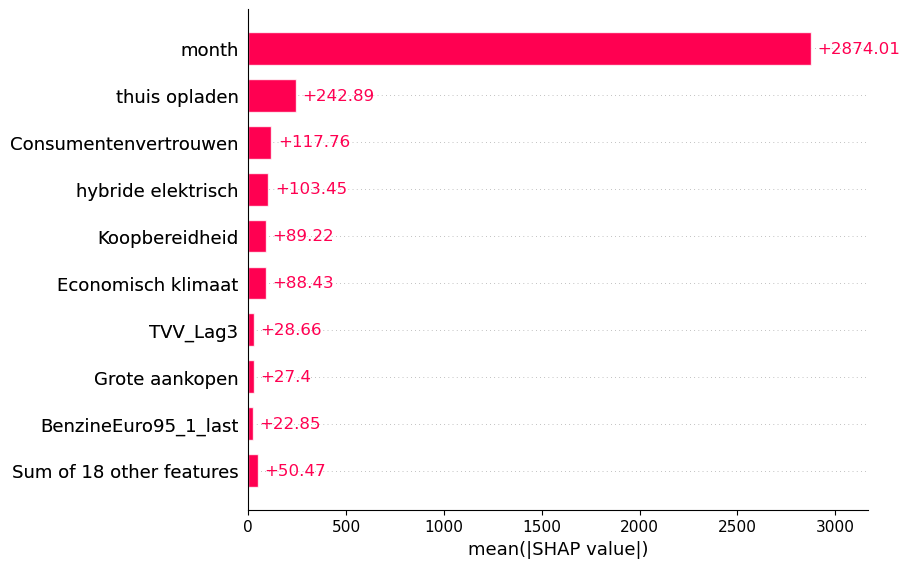

In [50]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

# 1. Verdeel data handmatig in train/test (gelijk aan je walk-forward verdeling)
initial_train_size = int(len(df_lagged) * 0.8)

X_all = df_lagged[feature_sets['All Features']]
y_all = df_lagged['Totaal_verkochte_wegvoertuigen']

X_train = X_all.iloc[:initial_train_size]
y_train = y_all.iloc[:initial_train_size]

X_test = X_all.iloc[initial_train_size:]
y_test = y_all.iloc[initial_train_size:]

# 2. Hertrain je beste model op alle trainingsdata
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_child_weight=1,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    reg_alpha=1,
    reg_lambda=0.1,
    tree_method='exact',
    random_state=42,
    eval_metric='rmse'
)
best_model.fit(X_train, y_train)

# 3. Bereken SHAP-waardes over de testset
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# 4. Toon globale feature importances (tabel of plot)
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)

# Print tabel
print("\n📊 Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):")
print(mean_abs_shap)

# 5. Optioneel: plot
shap.plots.bar(shap_values, max_display=10)  # top 10 meest bepalende features
